In [1]:
!pip install baycomp

In [2]:
import pandas as pd
from baycomp import SignedRankTest
import glob

In [3]:
files = glob.glob('../pipeline/results_homicides/*/by_folds/*')

In [4]:
results = {}
for file in files:
    splits = file.split('/')  
    
    if splits[3] not in results:
        results[splits[3]] = {}
    
    results[splits[3]][splits[5]] = pd.read_csv(file)
    
    results[splits[3]][splits[5]]['k'] = int(splits[3].split('_')[1])

In [5]:
knns = list(results.keys())

In [6]:
models = list(results[knns[0]].keys())

In [7]:
combinado = {}
for model in models:
    combinado[model] = pd.concat([results[k][model] for k in knns])

In [8]:
methods = {
    'cfs.csv'      : "CFS" ,
    'rrelieff.csv' : "RELIEFF", 
    'rf.csv'       : "RF",     
    'rfe.csv'      : "RFE",
}


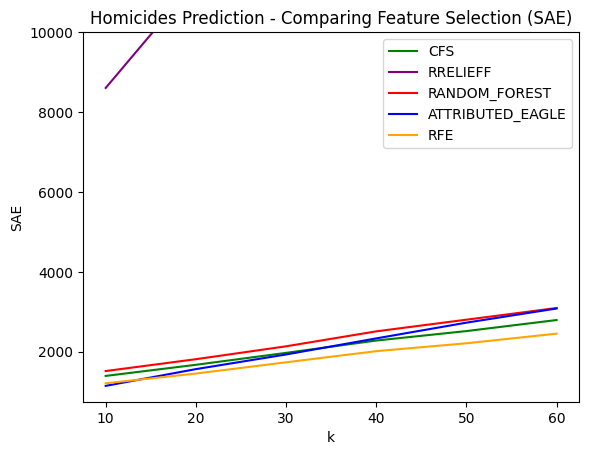

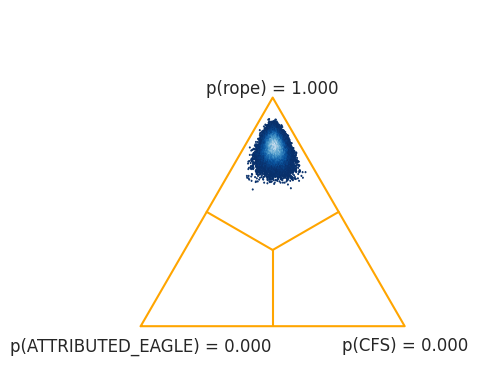

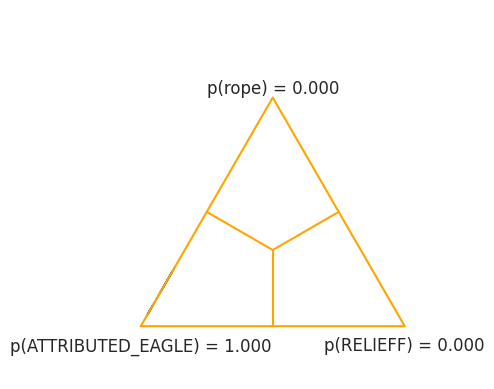

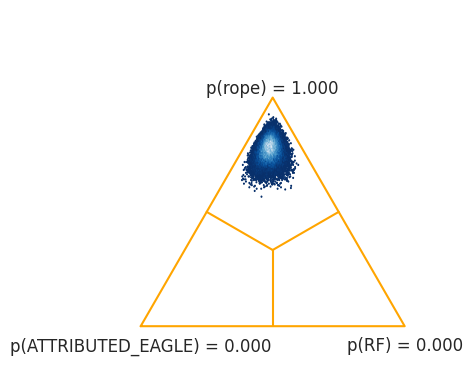

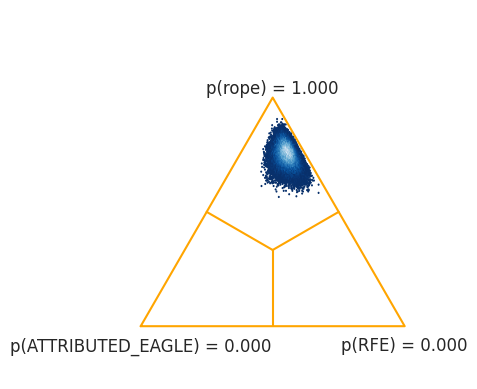

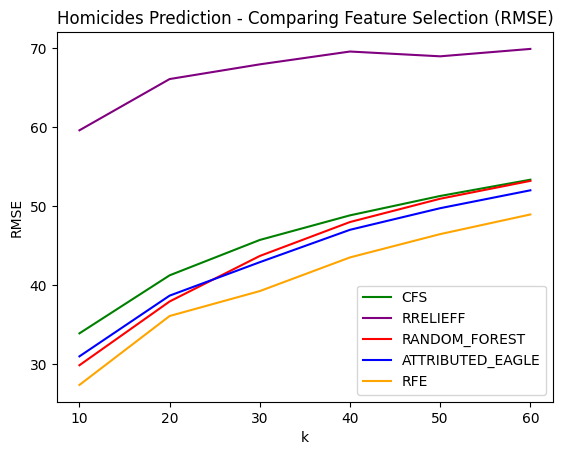

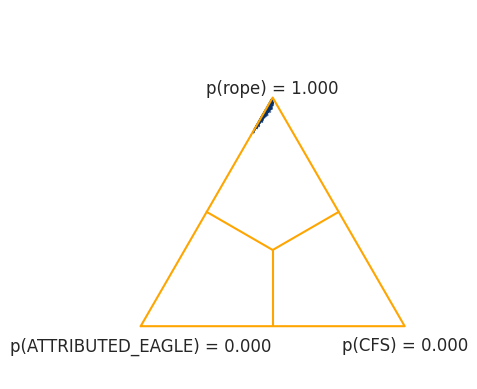

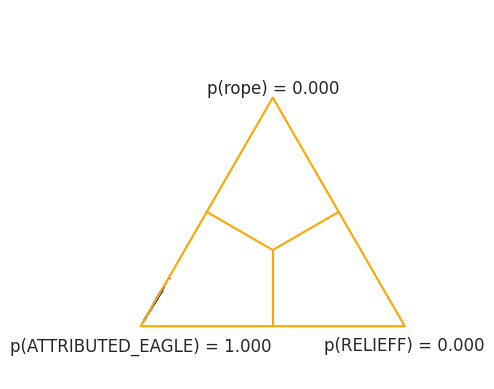

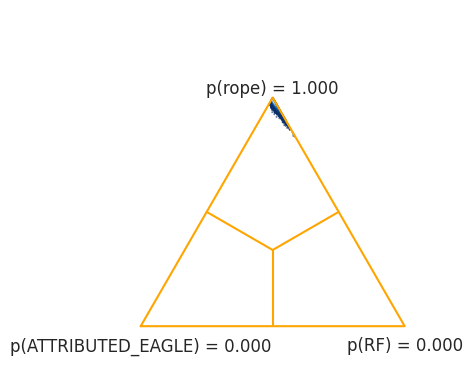

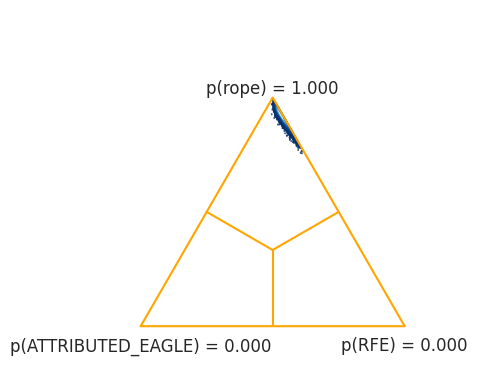

In [9]:
rename_mapping = {
    "cfs.csv": "CFS",
    "rrelieff.csv": "RRELIEFF",
    "rf.csv": "RANDOM_FOREST",
    "attributed_eagle_hom.csv": "ATTRIBUTED_EAGLE",
    "rfe.csv": "RFE"
}

colors = {
    "ATTRIBUTED_EAGLE": "blue",
    "CFS": "green",
    "RRELIEFF": "purple",
    "RANDOM_FOREST": "red",
    "RFE": "orange"
}

k_values = [10, 20, 30, 40, 50, 60]

for measure in ['sae', 'rmse']:
    tmp = pd.DataFrame({model:combinado[model].groupby('k')[measure].mean() for model in combinado.keys()})
    rope = max(0.02,tmp.std().mean())

    tmp.rename(columns=rename_mapping, inplace=True)

    tmp_filtered = tmp.loc[k_values]

    plot_title = f"Homicides Prediction - Comparing Feature Selection ({measure.upper()})"

    plot = tmp_filtered.plot(kind='line', title=plot_title, ylabel=measure.upper(), color=[colors[col] for col in tmp_filtered.columns])

    if measure in ['sae']:
        plot.set_ylim([750, 10000])  

    plot.set_xticks(k_values)
    plot.set_xticklabels([str(k) for k in k_values]) 

    fig = plot.get_figure()
    fig.savefig("./images/homicides_"+measure+".pdf")

    for k, v in methods.items():
        fig = SignedRankTest.plot(-combinado['attributed_eagle_hom.csv'][measure],
                                  -combinado[k][measure], rope=rope, names=["ATTRIBUTED_EAGLE",v])
        fig.savefig("./images/homicides_eagle_"+v.lower()+"_"+measure+".pdf")